# **3. 100 MW hybrid solar plant (CSP + PV)**

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

In [78]:
%store -r gen_pv
%store -r Production_pv
%store -r LCOE_pv_2021
%store -r LCOE_pv_2030
%store -r month_pv

**3.1.Defining Dispatch Schedules**

$gen_{csp}=base \ load - gen_{pv}$   
$gen_{csp}=100000[kW] - gen_{pv}$  
$gen_{csp}=gen_{residual}$  
$x\cdot Power \ Design=gen_{residual}$  
$x=\frac{gen_{residual}}{Power \ Design }$  
$x = Turbine \ \ ouput \ \ fraction$

In [79]:
gen_residual=100000-np.array(gen_pv)
#T_fraction=gen_residual/(0.9*P_ref*1000)
T_fraction=gen_residual/(100*1000)

In [80]:
Table_Jan=pd.DataFrame(T_fraction[0:744].reshape([31,24])).round(3)
Table_Feb=pd.DataFrame(T_fraction[744:1416].reshape([28,24])).round(3)
Table_Mar=pd.DataFrame(T_fraction[1416:2160].reshape([31,24])).round(3)
Table_Apr=pd.DataFrame(T_fraction[2160:2880].reshape([30,24])).round(3)
Table_May=pd.DataFrame(T_fraction[2880:3624].reshape([31,24])).round(3)
Table_Jun=pd.DataFrame(T_fraction[3624:4344].reshape([30,24])).round(3)
Table_Jul=pd.DataFrame(T_fraction[4344:5088].reshape([31,24])).round(3)
Table_Aug=pd.DataFrame(T_fraction[5088:5832].reshape([31,24])).round(3)
Table_Sept=pd.DataFrame(T_fraction[5832:6552].reshape([30,24])).round(3)
Table_Oct=pd.DataFrame(T_fraction[6552:7296].reshape([31,24])).round(3)
Table_Nov=pd.DataFrame(T_fraction[7296:8016].reshape([30,24])).round(3)
Table_Dec=pd.DataFrame(T_fraction[8016:8760].reshape([31,24])).round(3)

Table_annual=[Table_Jan,Table_Feb,Table_Mar,Table_Apr,Table_May,Table_Jun,Table_Jul,Table_Aug,Table_Sept,Table_Oct,Table_Nov,Table_Dec]

In [81]:
def Prod_Day(i):
  Day=[Table_Jan.iloc[i],Table_Feb.iloc[i],Table_Mar.iloc[i],Table_Apr.iloc[i],Table_May.iloc[i],Table_Jun.iloc[i],Table_Jul.iloc[i],Table_Aug.iloc[i],Table_Sept.iloc[i],Table_Oct.iloc[i],Table_Nov.iloc[i],Table_Dec.iloc[i]]
  Day=pd.DataFrame(Day)
  Day.index=range(0,12)
  return Day

Daily_factors=[]
for i in range(0,28):
  Daily_factors.append(Prod_Day(i))

In [82]:
Prod_28=[Table_Jan.iloc[28],np.zeros_like(Table_Jan.iloc[28]),Table_Mar.iloc[28],Table_Apr.iloc[28],Table_May.iloc[28],Table_Jun.iloc[28],Table_Jul.iloc[28],Table_Aug.iloc[28],Table_Sept.iloc[28],Table_Oct.iloc[28],Table_Nov.iloc[28],Table_Dec.iloc[28]]
Prod_28=pd.DataFrame(Prod_28)
Prod_28.index=range(0,12)
Daily_factors.append(Prod_28)

Prod_29=[Table_Jan.iloc[29],np.zeros_like(Table_Jan.iloc[29]),Table_Mar.iloc[29],Table_Apr.iloc[29],Table_May.iloc[29],Table_Jun.iloc[29],Table_Jul.iloc[29],Table_Aug.iloc[29],Table_Sept.iloc[29],Table_Oct.iloc[29],Table_Nov.iloc[29],Table_Dec.iloc[29]]
Prod_29=pd.DataFrame(Prod_29)
Prod_29.index=range(0,12)
Daily_factors.append(Prod_29)

Prod_30=[Table_Jan.iloc[30],np.zeros_like(Table_Jan.iloc[30]),Table_Mar.iloc[30],np.zeros_like(Table_Jan.iloc[30]),Table_May.iloc[30],np.zeros_like(Table_Jan.iloc[30]),Table_Jul.iloc[30],Table_Aug.iloc[30],np.zeros_like(Table_Jan.iloc[30]),Table_Oct.iloc[30],np.zeros_like(Table_Jan.iloc[30]),Table_Dec.iloc[30]]
Prod_30=pd.DataFrame(Prod_30)
Prod_30.index=range(0,12)
Daily_factors.append(Prod_30)

In [83]:
def Dispatch_Control(day,Daily_factors):
  Daily_factors_T=Daily_factors[day].T
  df1=pd.DataFrame()
  df2=pd.DataFrame()
  df3=pd.DataFrame()
  for i in range(0,12):
    min=Daily_factors_T[i].min()
    max=Daily_factors_T[i].max()
    delta=(max-min)/8
    if min!=0 and max!=0 :
      df1[i]=pd.cut(Daily_factors_T[i], bins=[min-delta,min,min+delta,min+2*delta,min+3*delta,min+4*delta,min+5*delta,min+6*delta,min+7*delta,max], labels=[min,min+delta,min+2*delta,min+3*delta,min+4*delta,min+5*delta,min+6*delta,min+7*delta,max])
      df2[i]=pd.cut(Daily_factors_T[i], bins=[min-delta,min,min+delta,min+2*delta,min+3*delta,min+4*delta,min+5*delta,min+6*delta,min+7*delta,max], labels=[1,2,3,4,5,6,7,8,9])
      df3[i]=[min,min+delta,min+2*delta,min+3*delta,min+4*delta,min+5*delta,min+6*delta,min+7*delta,max]
    else:
      df1[i]=np.ones(24)
      df2[i]=np.ones(24)
      df3[i]=np.ones(9)
  df1=df1.T
  df2=df2.T
  return [df1,df2,df3]

In [84]:
List_1=[] #List of standardized values
List_2=[] # Dispatch control
List_3=[] # f_turb values
for i in range(0,31):
  df=Dispatch_Control(i,Daily_factors)
  df1=df[0]
  df2=df[1]
  df3=df[2]
  List_1.append(df1)
  List_2.append(df2)
  List_3.append(df3)

In [85]:
for i in range(31):
  List_3[i] = List_3[i].apply(lambda x: [y if y >= 0.3 else 0.3 for y in x])

**3.2 Model Initialization**

In [86]:
import PySAM.Solarpilot as sp
import PySAM.TcsmoltenSalt as tcs
system_model_hybrid = tcs.default('MSPTSingleOwner')
%matplotlib inline

**3.3 SolarResource Group**

In [87]:
system_model_hybrid.SolarResource.solar_resource_file="Antofagasta.csv"

**3.4 System Design Group**

In [88]:
P_ref=111 #[MW]
Cycle_th_eff=0.412
S_M=2.5
Cycle_th_P=P_ref/Cycle_th_eff
tshours=15
system_model_hybrid.SystemDesign.P_ref=P_ref
system_model_hybrid.SystemDesign.solarm=S_M

In [89]:
model_opt1=sp.from_existing(system_model_hybrid)
model_opt1.SolarPILOT.helio_optical_error=0.00153
model_opt1.SolarPILOT.q_design=round(S_M*Cycle_th_P)
model_opt1.SolarPILOT.rec_aspect=21.6029/17.65
model_opt1.execute()

In [90]:
system_model_hybrid.SystemDesign.tshours=tshours
system_model_hybrid.HeliostatField.helio_positions=model_opt1.Outputs.heliostat_positions
system_model_hybrid.TowerAndReceiver.h_tower=model_opt1.Outputs.h_tower_opt
system_model_hybrid.TowerAndReceiver.rec_height=model_opt1.Outputs.rec_height_opt
system_model_hybrid.HeliostatField.N_hel=model_opt1.Outputs.number_heliostats
system_model_hybrid.TowerAndReceiver.D_rec=model_opt1.Outputs.rec_height_opt/model_opt1.Outputs.rec_aspect_opt
#system_model_hybrid.HeliostatField.A_sf_in=model_opt1.Outputs.area_sf
system_model_hybrid.HeliostatField.A_sf_in=model_opt1.SolarPILOT.helio_width*model_opt1.SolarPILOT.dens_mirror*model_opt1.SolarPILOT.helio_height*model_opt1.Outputs.number_heliostats

In [91]:
Jan_gen=[]
Feb_gen=[]
Mar_gen=[]
Apr_gen=[]
May_gen=[]
Jun_gen=[]
Jul_gen=[]
Aug_gen=[]
Sept_gen=[]
Oct_gen=[]
Nov_gen=[]
Dec_gen=[]

In [92]:
j=0
for i in range(0,31):
  system_model_hybrid.SystemControl.weekday_schedule=List_2[i].values.tolist()
  system_model_hybrid.SystemControl.weekend_schedule=List_2[i].values.tolist()
  for k in range(0,12):
    system_model_hybrid.SystemControl.f_turb_tou_periods=List_3[i].round(3)[k].values.tolist()
    system_model_hybrid.execute()
    if k==0: 
      Jan=system_model_hybrid.Outputs.gen[0:744]
      Jan_gen.append(Jan[j:j+24])
    if k==1 and i!=28 and i!=29 and i!=30:
      Feb=system_model_hybrid.Outputs.gen[744:1416]
      Feb_gen.append(Feb[j:j+24])
    if k==2:
      Mar=system_model_hybrid.Outputs.gen[1416:2160]
      Mar_gen.append(Mar[j:j+24])
    if k==3 and i!=30: 
      Apr=system_model_hybrid.Outputs.gen[2160:2880]
      Apr_gen.append(Apr[j:j+24])
    if k==4:
      May=system_model_hybrid.Outputs.gen[2880:3624]
      May_gen.append(May[j:j+24])
    if k==5 and i!=30: 
      Jun=system_model_hybrid.Outputs.gen[3624:4344]
      Jun_gen.append(Jun[j:j+24])
    if k==6:
      Jul=system_model_hybrid.Outputs.gen[4344:5088]
      Jul_gen.append(Jul[j:j+24])
    if k==7:
      Aug=system_model_hybrid.Outputs.gen[5088:5832]
      Aug_gen.append(Aug[j:j+24])
    if k==8 and i!=30: 
      Sept=system_model_hybrid.Outputs.gen[5832:6552]
      Sept_gen.append(Sept[j:j+24])
    if k==9:
      Oct=system_model_hybrid.Outputs.gen[6552:7296]
      Oct_gen.append(Oct[j:j+24])
    if k==10 and i!=30: 
      Nov=system_model_hybrid.Outputs.gen[6552:7296]
      Nov_gen.append(Nov[j:j+24])
    if k==11:
      Dec=system_model_hybrid.Outputs.gen[8016:8760]
      Dec_gen.append(Dec[j:j+24])
  j=j+24  

**3.6. Outputs Group**

In [93]:
gen_total=pd.DataFrame(Jan_gen+Feb_gen+Mar_gen+Apr_gen+May_gen+Jun_gen+Jul_gen+Aug_gen+Sept_gen+Oct_gen+Nov_gen+Dec_gen)

In [94]:
gen_comb=[]
for i in range(0,365):
  gen_comb=gen_comb+gen_total.iloc[i].tolist()

In [95]:
def LCOE_csp(d1,Site_prep,Solar_field,Fixed_tower_cost,Receiver_reference_cost,TES,Power_block,Contigencies,OM_fix,OM_var):
    Sum1=0
    Sum2=0
    t1=7/100
    for i in range(1,41):
        Sum1 = Sum1 + (((1-d1)**i)/((1+t1)**i))
        Sum2 = Sum2 + (1/((1+t1)**i))
    Production_csp_adapted=sum(np.array(gen_comb))
    Site_prep=Site_prep*system_model_hybrid.HeliostatField.A_sf_in
    Solar_field=Solar_field*system_model_hybrid.HeliostatField.A_sf_in
    Fixed_tower_cost=Fixed_tower_cost
    Tower_scaling_exp=0.0113
    Total_tower_cost=Fixed_tower_cost*math.exp(Tower_scaling_exp*(system_model_hybrid.TowerAndReceiver.h_tower-system_model_hybrid.TowerAndReceiver.rec_height/2+model_opt1.SolarPILOT.helio_height/2))
    Receiver_reference_cost=Receiver_reference_cost
    Receiver_area=math.pi*system_model_hybrid.TowerAndReceiver.D_rec*system_model_hybrid.TowerAndReceiver.rec_height
    Receiver_reference_area=1571
    Receiver_scaling_exponent=0.7
    Solar_receiver=Receiver_reference_cost*(Receiver_area/Receiver_reference_area)**Receiver_scaling_exponent
    #TES Thermal Capacity = Hours of Storage at Power Cycle Full Load × Cycle Thermal Input Power at Design
    #Cycle Thermal Power (MWt) = Design Turbine Gross Output (MWe) ÷ Cycle Thermal Efficiency
    Storage_capacity=(tshours*1000*P_ref)/Cycle_th_eff
    TES=TES*Storage_capacity
    #Balance_of_plant=290.00
    #Power_cycle_cost=1040.00
    #Power_block=(Balance_of_plant+Power_cycle_cost)*1000*P_ref
    Power_block=Power_block*1000*P_ref
    #Contigencies=5%

    CAPEX1=(Site_prep+Solar_field+Total_tower_cost+Solar_receiver+TES+Power_block)*Contigencies

    OPEX1=OM_fix*P_ref*1000+OM_var*Production_csp_adapted*(1/1000)

    LCOE_csp_adapted=((CAPEX1+OPEX1*Sum2)/(Production_csp_adapted*Sum1))*1000
    return(LCOE_csp_adapted)

In [96]:
LCOE_csp_adapted_2021=LCOE_csp(0.2/100,16.00,140,3000000.00,103000000.00,22,1330,105/100,66,3.5)
LCOE_csp_adapted_2030=LCOE_csp(0.1/100,10,50,2189781,75182481.75,10,700,102/100,44,2.3)

# <center> $LCOE_{hybrid}=\frac{LCOE_{PV}\cdot E_{PV}+LCOE_{CSP}\cdot E_{CSP}}{E_{PV}+E_{CSP}}$ <center>

**LCOE 2021**

In [97]:
LCOE_hybrid_2021=(LCOE_csp_adapted_2021*sum(np.array(gen_comb))+LCOE_pv_2021*Production_pv)/(sum(np.array(gen_comb))+Production_pv)
LCOE_hybrid_2021

65.8414710040822

**LCOE 2030**

In [98]:
LCOE_hybrid_2030=(LCOE_csp_adapted_2030*sum(np.array(gen_comb))+LCOE_pv_2030*Production_pv)/(sum(np.array(gen_comb))+Production_pv)
LCOE_hybrid_2030

33.49514373889901

In [99]:
sum(np.array(gen_pv)+np.array(gen_comb))/1000000

945.05868819905

In [100]:
gen_with_curtailment=np.array(gen_pv)+np.array(gen_comb)*0.96

for i in range(0,8760):
  if (gen_with_curtailment[i]>100000):
    gen_with_curtailment[i]=100000

In [101]:
sum(gen_with_curtailment)

824112868.0178679

In [102]:
Excess_energy=gen_comb-gen_with_curtailment

**CF - ELECT - HYBRID**

In [103]:
CF_hybrid=(sum(gen_with_curtailment))/(8760*0.9*111000)
CF_hybrid

0.941709823999648

In [104]:
gen_hybrid_limit=np.array(gen_with_curtailment)

for i in range(0,8760):
    if (gen_hybrid_limit[i]<100000*0.1):
        gen_hybrid_limit[i]=0
            
CF_elect_hybrid_alk=sum(gen_hybrid_limit)/(8760*0.9*111000)

# ${LCOH}_2=P_{inst}\bullet I\bullet\frac{FRC+M\left(f_p\right)}{h{\bullet f}_p\bullet Q_{H_2}}+Q_{H_2O}{\bullet P}_{H_2O}+Q_e\bullet P_e-Q_{O_2}\bullet P_{O_2}$


In [105]:
def LCOH(I,LCOE,f_p,eff,stack_lifetime=90000,percent_remp=0.4):
    P_inst=100 #Installed power of the electrolyser [MW]
    i=0.07
    h=8760 #Hours in a year
    N_rep=stack_lifetime/(f_p*h)
    I=I+I*percent_remp*(1-i)**N_rep
    n=30
    FRC=(i*((1+i)**n))/(((1+i)**n)-1)  #Capital Recovery Factor
    M=0.05 #Maintenance cost function as a percentage of investment, dependent on plant factor
    Q_h2=20.3 #Hydrogen production capacity [kg/h]
    Q_H2O=0.017  #Amount of water consumed [m3/kg of hydrogen]
    P_H2O=1.4 #Water price [USD/m3]
    Q_e=33.3/eff  #Amount of electricity consumed [kWh/kg of hydrogen]
    P_e=LCOE
    Q_O2=7.8 #Sale of oxygen taking into account the quantity produced [kgO2/kg of hydrogen] (optional term)
    P_O2=0.03 #Selling price of oxygen [USD/kgO2] (optional term)
    LCOH = I*(FRC+M)*33.3/(h*f_p*eff)+Q_H2O*P_H2O+Q_e*P_e
    
    Water=Q_H2O*P_H2O
    Electricity=Q_e*P_e
    Electrolysis=I*(FRC+M)*33.3/(h*f_p*eff)
    return(LCOH,Water,Electricity,Electrolysis)

**LCOH - HYBRID - ALK - 2021**

In [106]:
LCOH_hybrid_alk_2021=LCOH(500,LCOE_hybrid_2021/1000,CF_elect_hybrid_alk,0.63,100000)[0]
LCOH_hybrid_alk_2021

3.991772755999798

In [107]:
%store LCOH_hybrid_alk_2021

Stored 'LCOH_hybrid_alk_2021' (float64)


**LCOH - HYBRID - PEM - 2021**

In [108]:
LCOH_hybrid_PEM_2021=LCOH(1100,LCOE_hybrid_2021/1000,CF_hybrid,0.56)[0]
LCOH_hybrid_PEM_2021

5.1621028767311286

In [109]:
%store LCOH_hybrid_PEM_2021

Stored 'LCOH_hybrid_PEM_2021' (float64)


**LCOH - HYBRID - ALK - 2030**

In [110]:
LCOH_hybrid_alk_2030=LCOH(400,LCOE_hybrid_2030/1000,CF_elect_hybrid_alk,0.65,100000,0.15)[0]
LCOH_hybrid_alk_2030

2.0843521583368263

**LCOH - HYBRID - PEM - 2030**

In [111]:
LCOH_hybrid_PEM_2030=LCOH(650,LCOE_hybrid_2030/1000,CF_hybrid,0.63,percent_remp=0.15)[0]
LCOH_hybrid_PEM_2030

2.3750863658947314

In [112]:
W1 = [LCOH(500,LCOE_hybrid_2021/1000,CF_elect_hybrid_alk,0.63,100000)[1],LCOH(1100,LCOE_hybrid_2021/1000,CF_hybrid,0.56)[1]]
Electri1 = [LCOH(500,LCOE_hybrid_2021/1000,CF_elect_hybrid_alk,0.63,100000)[2],LCOH(1100,LCOE_hybrid_2021/1000,CF_hybrid,0.56)[2]]
Electro1 = [LCOH(500,LCOE_hybrid_2021/1000,CF_elect_hybrid_alk,0.63,100000)[3],LCOH(1100,LCOE_hybrid_2021/1000,CF_hybrid,0.56)[3]]

In [113]:
%store W1
%store Electri1
%store Electro1 

Stored 'W1' (list)
Stored 'Electri1' (list)
Stored 'Electro1' (list)


Text(0.5, 1.0, 'Levelised Cost of Hydrogen - CSP + PV hybrid')

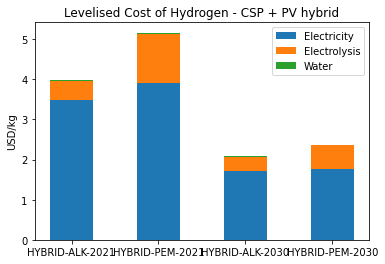

In [114]:
labels = ['HYBRID-ALK-2021',"HYBRID-PEM-2021","HYBRID-ALK-2030","HYBRID-PEM-2030"]
W = [LCOH(500,LCOE_hybrid_2021/1000,CF_elect_hybrid_alk,0.63,100000)[1],LCOH(1100,LCOE_hybrid_2021/1000,CF_hybrid,0.56)[1],LCOH(400,LCOE_hybrid_2030/1000,CF_elect_hybrid_alk,0.65,100000,0.15)[1],LCOH(650,LCOE_hybrid_2030/1000,CF_hybrid,0.63,percent_remp=0.15)[1]]
Electri = [LCOH(500,LCOE_hybrid_2021/1000,CF_elect_hybrid_alk,0.63,100000)[2],LCOH(1100,LCOE_hybrid_2021/1000,CF_hybrid,0.56)[2],LCOH(400,LCOE_hybrid_2030/1000,CF_elect_hybrid_alk,0.65,100000,0.15)[2],LCOH(650,LCOE_hybrid_2030/1000,CF_hybrid,0.63,percent_remp=0.15)[2]]
Electro = [LCOH(500,LCOE_hybrid_2021/1000,CF_elect_hybrid_alk,0.63,100000)[3],LCOH(1100,LCOE_hybrid_2021/1000,CF_hybrid,0.56)[3],LCOH(400,LCOE_hybrid_2030/1000,CF_elect_hybrid_alk,0.65,100000,0.15)[3],LCOH(650,LCOE_hybrid_2030/1000,CF_hybrid,0.63,percent_remp=0.15)[3]]
width = 0.5       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots()

bars = np.add(Electri, Electro).tolist()

ax.bar(labels, Electri, width, label='Electricity')
ax.bar(labels, Electro, width, bottom=Electri,label='Electrolysis')
ax.bar(labels, W, width, bottom=bars,label='Water')
ax.legend()

ax.set_ylabel("USD/kg")
ax.set_title('Levelised Cost of Hydrogen - CSP + PV hybrid')

#ax.bar(labels, women_means, width, bottom=men_means,label='Women')

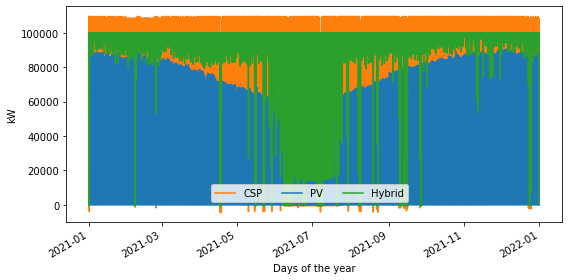

In [116]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, facecolor='w')
ax.plot(pd.date_range(start='1/1/2021', end='01/01/2022',periods=8760),gen_comb,label='CSP',c="tab:orange")
ax.plot(pd.date_range(start='1/1/2021', end='01/01/2022',periods=8760),gen_pv,label='PV',c="tab:blue")
ax.plot(pd.date_range(start='1/1/2021', end='01/01/2022',periods=8760),gen_with_curtailment,label='Hybrid',  c="tab:green")

ax.set_ylabel('kW')
ax.set_xlabel('Days of the year')
#ax.set_title('Hourly energy generated by the system')
ax.legend(loc=1, ncol=3, bbox_to_anchor=(0.7, 0.2))
plt.savefig("Ejemplo2.png")
fig.autofmt_xdate()

In [117]:
gen_csp=gen_comb
Sum_Enero=sum(gen_csp[0:744])
Sum_Febrero=sum(gen_csp[744:1416])
Sum_Marzo=sum(gen_csp[1416:2160])
Sum_Abril=sum(gen_csp[2160:2880])
Sum_Mayo=sum(gen_csp[2880:3624])
Sum_Junio=sum(gen_csp[3624:4344])
Sum_Julio=sum(gen_csp[4344:5088])
Sum_Agosto=sum(gen_csp[5088:5832])
Sum_Septiembre=sum(gen_csp[5832:6552])
Sum_Octubre=sum(gen_csp[6552:7296])
Sum_Noviembre=sum(gen_csp[7296:8016])
Sum_Diciembre=sum(gen_csp[8016:8760])

Month =[Sum_Enero, Sum_Febrero, Sum_Marzo, Sum_Abril, Sum_Mayo, Sum_Junio, Sum_Julio, Sum_Agosto, Sum_Septiembre, Sum_Octubre, Sum_Noviembre,Sum_Diciembre]

<ipython-input-118-7bcc1d05fd60>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(Months)


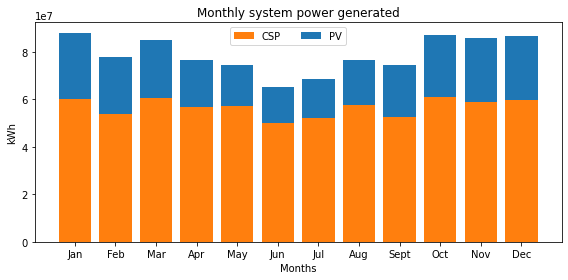

In [118]:
Months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, facecolor='w')

ax.bar(range(12), 
       height=Month,
       label='CSP',
       width=0.8, bottom=0, align='center', 
       color="tab:orange", edgecolor=None, linewidth=None); 
ax.bar(range(12), 
       height=month_pv,
       bottom=Month,
       label='PV',
       #width=0.8, bottom=0, align='center', 
       color="tab:blue", edgecolor=None, linewidth=None); 
ax.set_ylabel('kWh')
ax.set_xlabel('Months')
ax.set_title('Monthly system power generated')
ax.legend(loc=1, ncol=3, bbox_to_anchor=(0.6, 1))
ax.set_xticklabels(Months)
ax.set_xticks(range(12))

In [120]:
LHV=33.3 #(kWh/KgH2)
eff_PEM=0.56
eff_ALK=0.63
df1=pd.DataFrame(np.array(Month)*0.96+np.array(month_pv))
df1["PEM"]=(df1[0]/(LHV/eff_PEM + 6.4))*(LHV/eff_PEM)
df1["Liq"]=(df1[0]/(LHV/eff_PEM + 6.4))*6.4
df1["Alk"]=(df1[0]/(LHV/eff_ALK + 6.4))*(LHV/eff_ALK)
df1["Liq1"]=(df1[0]/(LHV/eff_ALK + 6.4))*6.4
df1["PEM1"]=(df1[0]/(LHV/eff_PEM + 1.05))*(LHV/eff_PEM)
df1["Comp"]=(df1[0]/(LHV/eff_PEM + 1.05))*1.05
df1["Alk1"]=(df1[0]/(LHV/eff_ALK + 1.05))*(LHV/eff_ALK)
df1["Comp1"]=(df1[0]/(LHV/eff_ALK + 1.05))*1.05

Months=["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sept","Oct","Nov","Dec"]
df1.index=Months
df1.columns=["Energy", "PEM","Liq","Alk","Liq1","PEM1","Comp","Alk1","Comp1"]

<ipython-input-121-a3e2c7154301>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 0].set_xticklabels(Months)
<ipython-input-121-a3e2c7154301>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0, 1].set_xticklabels(Months)
<ipython-input-121-a3e2c7154301>:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1, 0].set_xticklabels(Months)
<ipython-input-121-a3e2c7154301>:77: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1, 1].set_xticklabels(Months)


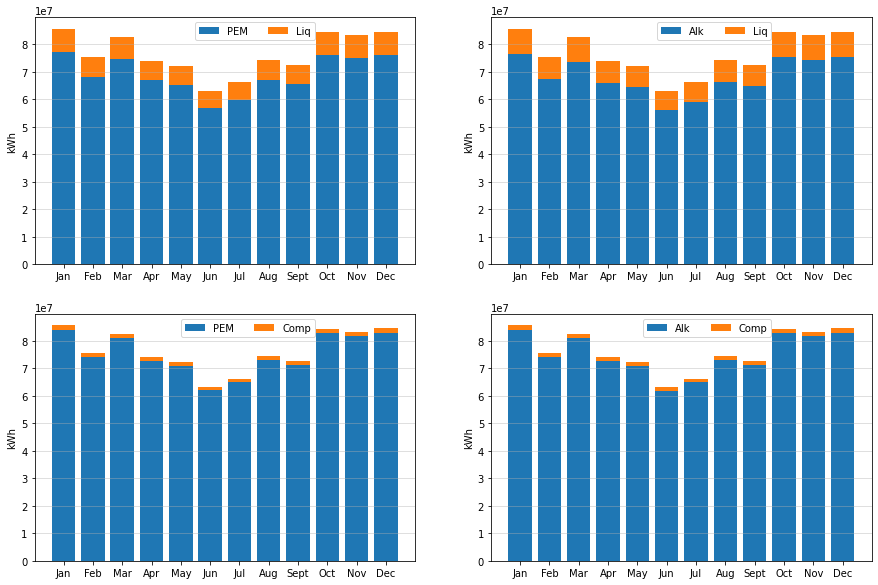

In [121]:
x=range(12)
fig, ax = plt.subplots(2, 2)
fig.set_size_inches(15, 10)

ax[0, 0].bar(x=range(12), 
       height=df1["PEM"],
       label='PEM',
       width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[0, 0].bar(x=range(12), 
       height=df1["Liq"],
       bottom=df1["PEM"],
       label='Liq',
       #width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[0, 0].set_ylabel('kWh')
#ax[0, 0].set_xlabel('Months')
#ax[0, 0].set_title('Monthly system power generated')
ax[0, 0].legend(loc=1, ncol=3, bbox_to_anchor=(0.75, 1))
ax[0, 0].set_xticklabels(Months)
ax[0, 0].set_xticks(range(12))
ax[0, 0].grid(alpha=0.5,axis='y')

ax[0, 1].bar(x=range(12), 
       height=df1["Alk"],
       label='Alk',
       width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[0, 1].bar(x=range(12), 
       height=df1["Liq1"],
       bottom=df1["Alk"],
       label='Liq',
       #width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[0, 1].set_ylabel('kWh')
#ax[0, 1].set_xlabel('Months')
#ax[0, 1].set_title('Monthly system power generated')
ax[0, 1].legend(loc=1, ncol=3, bbox_to_anchor=(0.75, 1))
ax[0, 1].set_xticklabels(Months)
ax[0, 1].set_xticks(x)
ax[0, 1].grid(alpha=0.5,axis='y')

ax[1, 0].bar(x=range(12), 
       height=df1["PEM1"],
       label='PEM',
       width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[1, 0].bar(x=range(12), 
       height=df1["Comp"],
       bottom=df1["PEM1"],
       label='Comp',
       #width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[1, 0].set_ylabel('kWh')
#ax[1, 0].set_xlabel('Months')
#ax[1, 0].set_title('Monthly system power generated')
ax[1, 0].legend(loc=1, ncol=3, bbox_to_anchor=(0.75, 1))
ax[1, 0].set_xticklabels(Months)
ax[1, 0].set_xticks(x)
ax[1, 0].grid(alpha=0.5,axis='y')

ax[1, 1].bar(x=range(12), 
       height=df1["Alk1"],
       label='Alk',
       width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[1, 1].bar(x=range(12), 
       height=df1["Comp1"],
       bottom=df1["Alk1"],
       label='Comp',
       #width=0.8, bottom=0, align='center', 
       color=None, edgecolor=None, linewidth=None); 
ax[1, 1].set_ylabel('kWh')
#ax[1, 1].set_xlabel('Months')
#ax[1, 1].set_title('Monthly system power generated')
ax[1, 1].legend(loc=1, ncol=3, bbox_to_anchor=(0.75, 1))
ax[1, 1].set_xticklabels(Months)
ax[1, 1].set_xticks(x)
ax[1, 1].grid(alpha=0.5,axis='y')

In [122]:
gen_csp=gen_with_curtailment
Sum_Enero=sum(gen_csp[0:744])
Sum_Febrero=sum(gen_csp[744:1416])
Sum_Marzo=sum(gen_csp[1416:2160])
Sum_Abril=sum(gen_csp[2160:2880])
Sum_Mayo=sum(gen_csp[2880:3624])
Sum_Junio=sum(gen_csp[3624:4344])
Sum_Julio=sum(gen_csp[4344:5088])
Sum_Agosto=sum(gen_csp[5088:5832])
Sum_Septiembre=sum(gen_csp[5832:6552])
Sum_Octubre=sum(gen_csp[6552:7296])
Sum_Noviembre=sum(gen_csp[7296:8016])
Sum_Diciembre=sum(gen_csp[8016:8760])

comb1 =np.array([Sum_Enero, Sum_Febrero, Sum_Marzo, Sum_Abril, Sum_Mayo, Sum_Junio, Sum_Julio, Sum_Agosto, Sum_Septiembre, Sum_Octubre, Sum_Noviembre,Sum_Diciembre])

In [123]:
#2021

LHV=33.3 #(kWh/KgH2)
eff_PEM=0.56
eff_ALK=0.63
H2_PEM_Liq=(comb1/(LHV/eff_PEM+6.4))*(1/1000)
H2_PEM_Comp=(comb1/(LHV/eff_PEM+1.05))*(1/1000)
H2_Alk_Liq=(comb1/(LHV/eff_ALK+6.4))*(1/1000)
H2_Alk_Comp=(comb1/(LHV/eff_ALK+1.05))*(1/1000)

<ipython-input-124-f33d6df73240>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(Months)


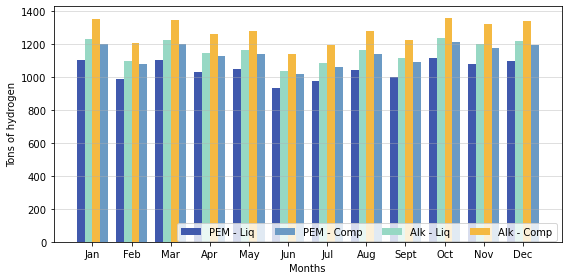

In [124]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, facecolor='w')
y=np.arange(12)
width1 = 0.2
ax.bar(y - 1.5*width1, 
       height=H2_PEM_Liq,
       label="PEM - Liq",
       width=0.2, color="#4059AD"); 

ax.bar(y +1.5*width1, 
       height=H2_PEM_Comp,
       label='PEM - Comp',
       width=0.2,color="#6B9AC4"); 

ax.bar(y-0.5*width1, 
       height=H2_Alk_Liq,
       label='Alk - Liq',
       width=0.2,color="#97D8C4"); 

ax.bar(y + 0.5*width1, 
       height=H2_Alk_Comp,
       label='Alk - Comp',
       width=0.2, color="#F4B942"); 
       
ax.set_ylabel('Tons of hydrogen')
ax.set_xlabel('Months')
#ax.set_title('Monthly Hydrogen Production 2021')
ax.legend(loc=1, ncol=4, bbox_to_anchor=(1, 0.1))
ax.set_xticklabels(Months)
ax.set_xticks(y)
ax.grid(alpha=0.5,axis='y')

In [125]:
#2030
LHV=33.3 #(kWh/KgH2)
eff_PEM=0.63
eff_ALK=0.65
H2_PEM_Liq=(comb1/(LHV/eff_PEM+6.4))*(1/1000)
H2_PEM_Comp=(comb1/(LHV/eff_PEM+1.05))*(1/1000)
H2_Alk_Liq=(comb1/(LHV/eff_ALK+6.4))*(1/1000)
H2_Alk_Comp=(comb1/(LHV/eff_ALK+1.05))*(1/1000)

<ipython-input-126-5eb60a101b71>:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(Months)


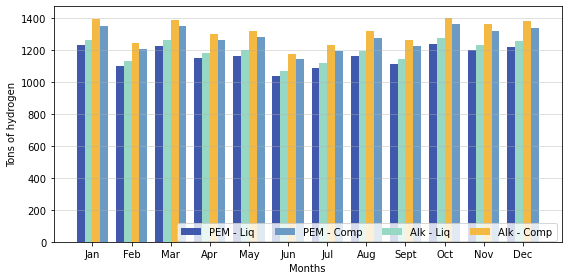

In [126]:
fig, ax = plt.subplots(figsize=(8, 4), tight_layout=True, facecolor='w')
y=np.arange(12)
width1 = 0.2
ax.bar(y - 1.5*width1, 
       height=H2_PEM_Liq,
       label="PEM - Liq",
       width=0.2, color="#4059AD"); 

ax.bar(y +1.5*width1, 
       height=H2_PEM_Comp,
       label='PEM - Comp',
       width=0.2,color="#6B9AC4"); 

ax.bar(y-0.5*width1, 
       height=H2_Alk_Liq,
       label='Alk - Liq',
       width=0.2,color="#97D8C4"); 

ax.bar(y + 0.5*width1, 
       height=H2_Alk_Comp,
       label='Alk - Comp',
       width=0.2, color="#F4B942"); 
       
ax.set_ylabel("Tons of hydrogen")
ax.set_xlabel('Months')
#ax.set_title('Monthly Hydrogen Production 2021')
ax.legend(loc=1, ncol=4, bbox_to_anchor=(1, 0.1))
ax.set_xticklabels(Months)
ax.set_xticks(y)
ax.grid(alpha=0.5,axis='y')

In [127]:
day_prod=(sum(gen_with_curtailment)/365)*0.63/33.3
flow_max=np.array(gen_with_curtailment).max()*0.63/33.3

In [128]:
#Compressed hydrogen gas storage system

i=0.07
n_conversion=15
n_storage=20

FRC_conversion=(i*((1+i)**n_conversion))/(((1+i)**n_conversion)-1)
FRC_storage=(i*((1+i)**n_storage))/(((1+i)**n_storage)-1)

M_storage=2/100
M_conversion=4/100

storage_module=500*day_prod*((FRC_storage+M_storage)/(sum(gen_with_curtailment)*0.63/33.3))  #USD
conversion_module=3900*flow_max*1.05*((FRC_conversion+M_conversion)/(sum(gen_with_curtailment)*0.63/33.3))

GH2=storage_module+conversion_module

In [129]:
GH2

0.23113528090517976

In [130]:
#Liquid hydrogen

i=0.07
n_conversion=20
n_storage=20

FRC_conversion=(i*((1+i)**n_conversion))/(((1+i)**n_conversion)-1)
FRC_storage=(i*((1+i)**n_storage))/(((1+i)**n_storage)-1)

M_storage=2/100
M_conversion=8/100



storage_module=90*day_prod*((FRC_storage+M_storage)/(sum(gen_with_curtailment)*0.63/33.3))  #USD
conversion_module=50000*flow_max*((FRC_conversion+M_conversion)/(sum(gen_with_curtailment)*0.63/33.3))
LH2=storage_module+conversion_module

In [131]:
LH2

1.0862710465219878